**извлечение признаков из текста на естественном языке**

классификатор текстов лемматизация+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

In [7]:
# !pip install pymorphy2

In [8]:
from pymorphy2 import MorphAnalyzer

## тексты

In [9]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
1976,"13 декабря 2016, 09:10\n\nАмериканские фондовые индикаторы преимущественно снизились по итогам вчерашних торгов, однако индекс Dow Jones достиг исторического максимума — шестую сессию подряд.\n\nП...",economics
1046,"Деньги, которые нужны бизнесу\n\n2 декабря 2016 в 8:59\n\nFINANCE.TUT.BY\n\nСегодня белорусские компании столкнулись со снижением спроса потребителей на товары и услуги, которые раньше имели больш...",economics


## токенизация и очистка

In [10]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [11]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()


# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [12]:
data['ctext'] = data['text'].progress_apply(string_normalizer).progress_apply( tokenize_normalize )

  0%|          | 0/3196 [00:00<?, ?it/s]

  0%|          | 0/3196 [00:00<?, ?it/s]

In [13]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22673 слов


In [14]:
data['ctext'] = data['ctext'].apply( ' '.join  )

In [15]:
data.sample(10)

,text,tag,ctext
1099,Вратарь ЦСКА установил уникальный рекорд Лиги чемпионов\n\n8 декабря 2016 в 11:23\n\nSPORT.TUT.BY\n\nВратарь ЦСКА Игорь Акинфеев в последнем матче группового этапа Лиги чемпионов против «Тоттенхэм...,sport,вратарь цска установить уникальный рекорд лига чемпион декабрь вратарь цска игорь последний матч групповой этап лига чемпион забить гол свой ворота своеобразный рекорд турнир матч закончить...
2107,"Мадрид, , 10:06 — REGNUM Мадридский «Атлетико» с крупным счетом уступил «Вильярреалу» в матче пятнадцатого тура чемпионата Испании по футболу. Встреча, прошедшая 12 декабря на стадионе «Эль-Мадриг...",sport,мадрид мадридский крупный счёт уступить матч пятнадцатый тур чемпионат испания футбол встреча прошедший декабрь стадион завершиться счёт победа жёлтый субмарина принести точный удар мануэл...
2421,"Натали Портман и Кейси Аффлек получили призы кинокритиков за актерские работы\n\nFacebook ВКонтакте Twitter Google+\n\nКадр из фильма ""Джеки""\n\nCritics' Choice – крупнейшая премия ассоциации кино...",culture,натали получить приз кинокритик актёрский работа вконтакте кадр фильм джеки крупный премия ассоциация кинокритик сша канада который состоять критик вручаться работа кино телеэкран сч...
2037,"(обновлено 08:09 13.12.2016 )\n\nМОСКВА, 13 дек - Р-Спорт. Две голевые передачи российского нападающего Евгения Малкина помогли хоккеистам ""Питтсбурга"" разгромить ""Аризону"" в матче регулярного чем...",sport,москва дек голевой передача российский евгений малкин помочь хоккеист питтсбург аризона матч регулярный чемпионат нхл встреча прошедший понедельник лёд питтсбург завершиться счёт польза хоз...
1445,"Избранный президент США Дональд Трамп принял решение отложить пресс-конференцию, на которой он объявит о своем уходе из бизнеса, сообщила его пресс-секретарь Хоуп Хикс.\n\nВ качестве причин перено...",politics,избранный президент сша дональд трамп принять решение пресс-конференция который объявить свой уход бизнес сообщить пресс-секретарь качество причина перенос представитель администрация трамп...
194,Ющенко поручил Кабмину создать Комитет по противодействию ВИЧ/СПИД Ющенко\nпоручил Кабмину создать при Министерстве здравоохранения Комитет по\nвопросам противодействия ВИЧ/СПИД и другим социально...,politics,ющенко поручить кабмин комитет противодействие вич спид ющенко поручить кабмин министерство здравоохранение комитет вопрос противодействие вич спид другой опасный болезнь февраль год гово...
1943,"Избранный президент США Дональд Трамп одержал победу на выборах главы государства в штатах Висконсин и Пенсильвания, свидетельствуют утвержденные итоги пересчета голосов, который ранее был инициир...",politics,избранный президент сша дональд трамп одержать победа выборы глава государство штат висконсин пенсильвания свидетельствовать итог пересчёт голос который быть лидер зелёный пересчёт голос вис...
3161,"ИТАР-ТАСС Урал (tass-ural.ru) Правительство Югры и Внешэкономбанк\nдоговорились о совместной деятельности по развитию государственно-частного\nпартнерства в автономном округе. ТЮМЕНЬ, 19 июля. /К...",economics,итар-тасс урал правительство югра внешэкономбанк договориться совместный деятельность развитие государственно-частный партнёрство автономный округ тюмень июль итар-тасс владимир зуёк правитель...
2738,"В сети начали жаловаться на рекламу во время прослушивания музыки «ВКонтакте». Такие записи стали появляться во многих пабликах.\n\nИрина Гурт\n\nПост о том, что при желании послушать музыку прямо...",tech,сеть начать реклама время прослушивание музыка вконтакте такой запись стать многий ирина гурт пост тот желание музыка вконтакте сам композиция появляться реклама один набрать челове...
1340,Смотрите необычное поздравление TUT.BY с Новым годом — в формате 360-градусного видео\n\n2 декабря 2016 в 14:49\n\n42.TUT.BY\n\nTUT.BY поздравляет всех своих читателей с наступающим Рождеством и Н...,social,смотреть необычный поздравление новый год формат видео декабрь поздравлять весь свой читатель рождество новый год этот

##  Vectorizer

In [16]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w
            
tf = TfidfVectorizer(use_idf=True, norm='l2', tokenizer=tokenizer, token_pattern=None).fit( data['ctext'] )
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

22672


In [17]:
# разница между исходным словарём и словарём векторайзера
set(vcb0)^set(vcb1)

{''}

## формируем датасеты

In [18]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 22672)

In [19]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [20]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [21]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 22672), (2237,), (959, 22672), (959,))

## обучаем классификатор

In [22]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [23]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [24]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8706986444212722

In [25]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.94      0.90      0.92        87
           1       0.85      0.96      0.90       101
           2       0.84      0.82      0.83        76
           3       0.88      0.74      0.81        31
           4       0.89      0.91      0.90       123
           5       0.88      0.95      0.92       177
           6       0.74      0.67      0.70        21
           7       1.00      0.47      0.64        17
           8       0.81      1.00      0.89        68
           9       0.47      0.39      0.42        44
          10       0.99      1.00      1.00       118
          11       0.87      0.74      0.80        89
          12       1.00      0.57      0.73         7

    accuracy                           0.87       959
   macro avg       0.86      0.78      0.80       959
weighted avg       0.87      0.87      0.87       959



---

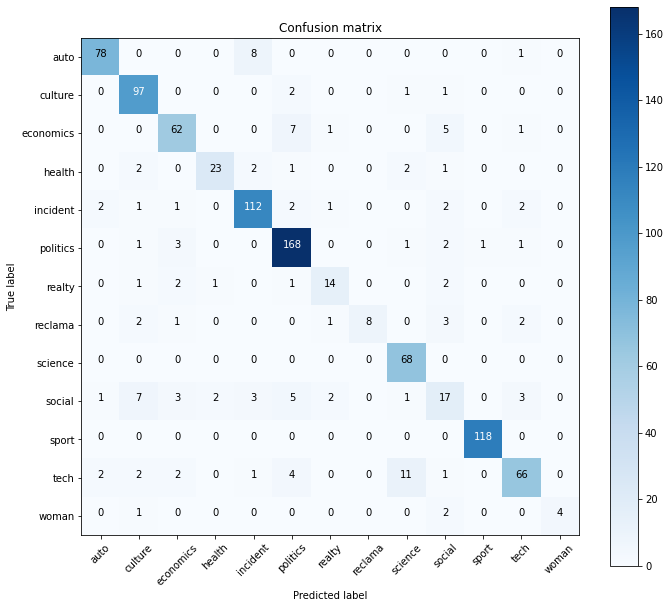

In [26]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [27]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }
# labels_inv

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: sport
predict: sport
Минское "Динамо" потерпело третье домашнее поражение подряд 4 декабря 2016 в 19:21 SPORT.TUT.BY / Фото: Дарья Бурякина Минское «Динамо» проиграло дома магнитогорскому «Металлургу» — 2:4 (0:2, 2:1, ...
- - - - - - - - - - - - - - - - - -
tag: economics
predict: economics
Сырая нефть Цены на нефть в понедельник подскочили на 5% после того, как страны, не входящие в ОПЕК, достигли соглашения насчет урезания добычи нефти на 558 тыс. баррелей. Россия дала обещание урезат...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Wall Street Journal: "Беларусь становится Кремниевой долиной Восточной Европы" 7 декабря 2016 в 10:16 42.TUT.BY Американская деловая газета The Wall Street Journal опубликовала статью об успехах Бе...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
Нападающий "Филадельфии" Якуб Ворачек стал лучшим игроком недели в НХЛ, информирует официальный сайт НХЛ. В четырех встречах он забросил три шайбы и сделал шесть результативных 

In [28]:
# https://habr.com/ru/post/205360/